# Analysis on Kickstarter

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from rdd import rdd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
# Show all columns
pd.set_option('display.max_columns', None)


# Function for Kernels

In [2]:
class Kernels:
    def __init__(self):
        pass
        

    # Triangular kernel
    def triangular_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (1 - np.abs(R - c) / h)
    
    # Epanechnikov kernel
    def epanechnikov_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (3/4) * (1 - ((R - c) / h) ** 2)
    

# Plotting Dataframe Generation

In [ ]:
# Generate Plotting Dataframe
def generate_plotting_df(data):
    cutoff = 0
    bandwidth = 10000
    bin_size = 20

    plotting_df = data.copy()

    plotting_df = plotting_df[(plotting_df['dollars_to_goal'] <= 10000) & (plotting_df['dollars_to_goal'] >= -10000)]
    # Split data into left and right of the cutoff
    left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff)]
    right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff)]

    # Bin each subset separately
    left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=20)
    right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=20)

    # Aggregate the binned data for each subset
    left_binned_data = left_df.groupby('dollars_to_goal_binned').agg({
        'total_successful_after_first': 'mean',
        'total_failed_after_first': 'mean',
        'total_canceled_after_first': 'mean',
        'total_raised_after_first_usd': 'mean',
        'total_campaigns_after_first': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
    right_binned_data = right_df.groupby('dollars_to_goal_binned').agg({
        'total_successful_after_first': 'mean',
        'total_failed_after_first': 'mean',
        'total_canceled_after_first': 'mean',
        'total_raised_after_first_usd': 'mean',
        'total_campaigns_after_first': 'mean',
        'dollars_to_goal': 'size',  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

    # Add a midpoint for each bin for both left and right data
    left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
    right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

    #left_binned_data['dollars_to_goal_2'] = left_binned_data['dollars_to_goal'] ** 2
    #right_binned_data['dollars_to_goal_2'] = right_binned_data['dollars_to_goal'] ** 2
    # Combine the binned data for both sides of the cutoff
    plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)

    return plotting_df

In [4]:
# Load the data
df = pd.read_json('../data/creator_first_project.json', lines = True)
df.shape

(328652, 148)

# Visualize the Data

Text(0.5, 1.0, 'New Kickstarter Creators by Year')

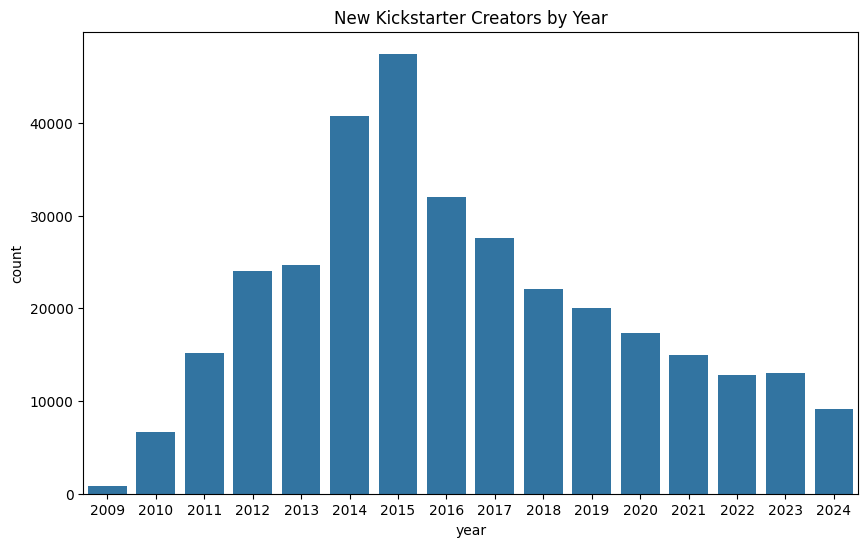

In [5]:
# New Kickstarter Creators by Year
df['year'] = df['launched_at'].dt.year
df['month'] = df['launched_at'].dt.month

# Plot
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='year')
plt.title('New Kickstarter Creators by Year')

## Check first project statistics

In [6]:
# Convert some key statistics to integers
df['spotlight'] = df['spotlight'].astype(int)

# Replace missing with zeros for prelaunch_activated
df['prelaunch_activated'] = df['prelaunch_activated'].fillna(0)

In [7]:
df[['usd_goal', 'usd_pledged', 'staff_pick', 'backers_count', 'spotlight', 'prelaunch_activated', 'total_raised_after_first']].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,usd_goal,usd_pledged,staff_pick,backers_count,spotlight,prelaunch_activated,total_raised_after_first
count,328652.00,328652.00,321019.00,328652.00,328652.00,328652.00,32889.00
mean,39749.07,12231.96,0.11,129.54,0.50,0.08,166221.98
std,1049282.91,97368.42,0.32,936.50,0.50,0.28,1799620.83
min,0.51,0.00,0.00,0.00,0.00,0.00,1.00
25%,2000.00,73.21,0.00,3.00,0.00,0.00,2707.00
50%,5000.00,1228.00,0.00,21.00,0.00,0.00,9246.00
75%,15000.00,6055.00,0.00,77.00,1.00,0.00,34974.00
max,152350076.00,13285226.36,1.00,219382.00,1.00,1.00,120530708.00


Define the Discontinuity

In [8]:
# Create Discontinuity Columns
df['percent_to_goal'] = df['usd_pledged'] / df['usd_goal']
df['dollars_to_goal'] = df['usd_pledged']  - df['usd_goal']

## Percent to Goal

C:\Users\d0tam\AppData\Local\Temp\ipykernel_29768\1269238025.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_29768\1269238025.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_29768\1269238025.py:19: FutureWarning: The default of observed=False is deprec

<Axes: xlabel='percent_to_goal', ylabel='Count'>

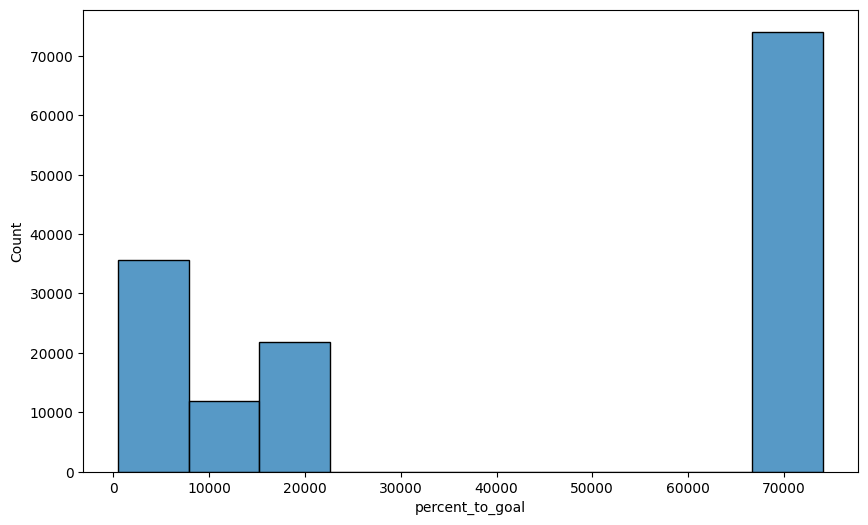

In [46]:

plotting_df = generate_plotting_df(df)

# Plot percent to goal on x axis and total number of projects on y axis
plt.figure(figsize=(10,6))
#plt.xlim(0, 2)
sns.histplot(data=plotting_df, x='percent_to_goal', weights = 'n_obs')

Text(0.5, 0, 'Percent to Goal')

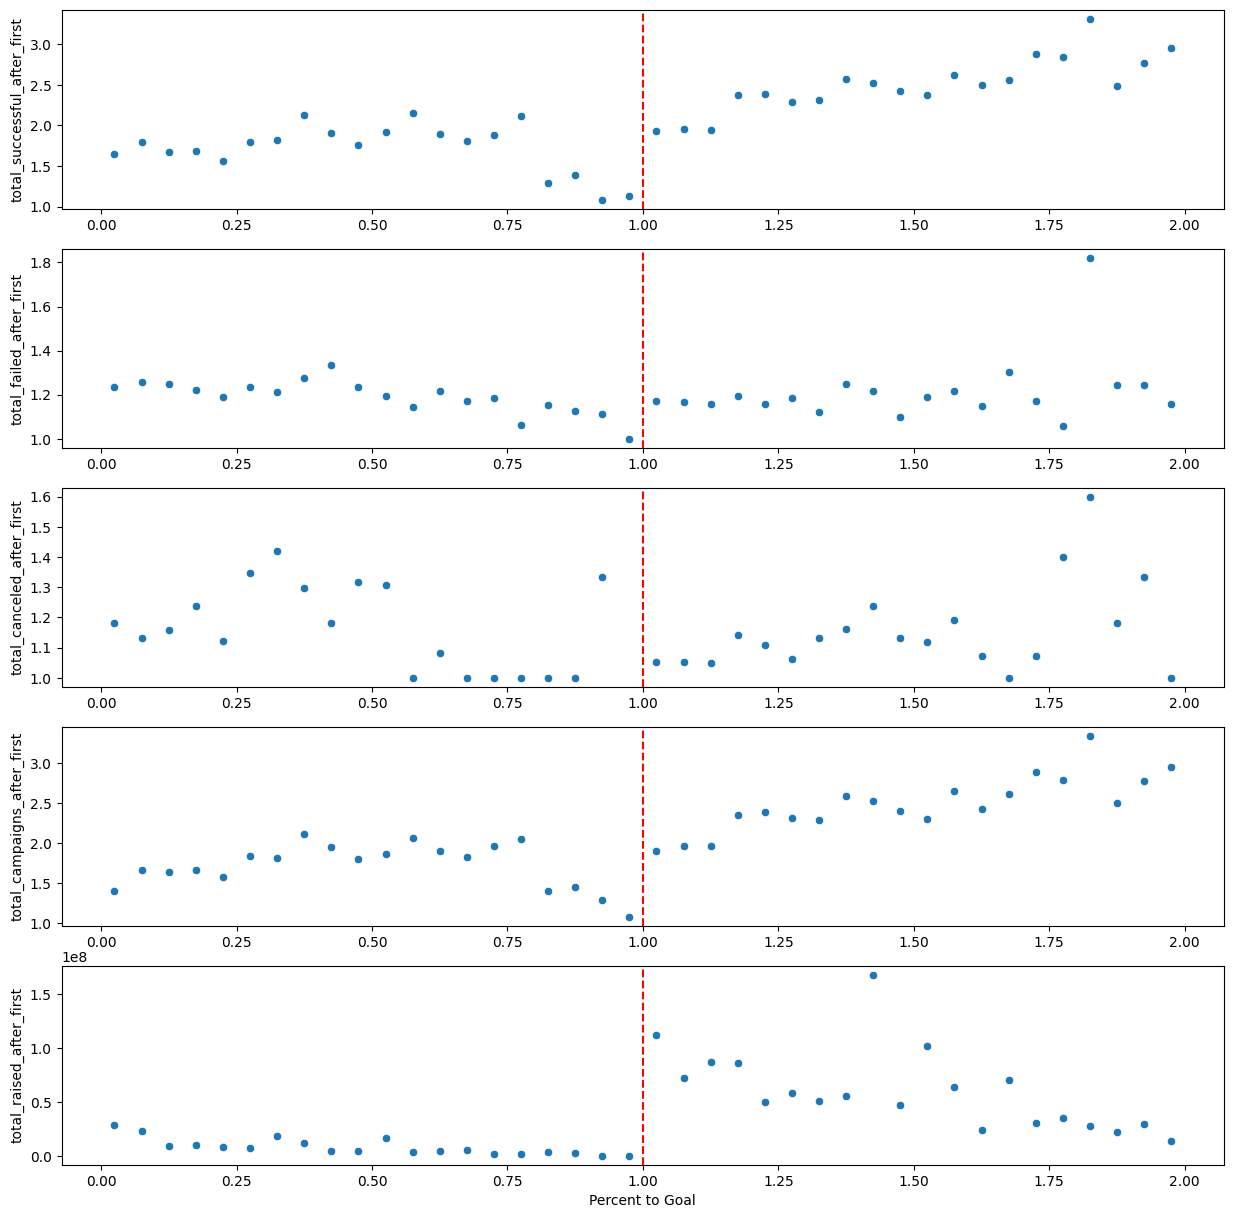

In [10]:
plt.figure(figsize=(15,15))
ax = plt.subplot(5, 1, 1)

sns.scatterplot(data=plotting_df, x = 'percent_to_goal', y = 'total_successful_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 2)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_failed_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 3)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_canceled_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 4)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_campaigns_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 5)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_raised_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('Percent to Goal')


In [11]:
plotting_df

,percent_to_goal_binned,total_successful_after_first,total_failed_after_first,total_canceled_after_first,total_raised_after_first,total_campaigns_after_first,n_obs,percent_to_goal,threshold
0,"(-0.001, 0.05]",1.649340,1.235171,1.180301,2.852164e+07,1.402683,80376,0.0245,False
1,"(0.05, 0.1]",1.793201,1.257709,1.130435,2.285252e+07,1.663172,15566,0.0750,False
2,"(0.1, 0.15]",1.677966,1.248016,1.157143,9.270335e+06,1.635342,9886,0.1250,False
3,"(0.15, 0.2]",1.688841,1.223188,1.238095,1.056213e+07,1.670199,6765,0.1750,False
4,"(0.2, 0.25]",1.563348,1.189474,1.121212,8.151370e+06,1.576071,5317,0.2250,False
5,"(0.25, 0.3]",1.800000,1.233831,1.346154,7.615889e+06,1.837338,3854,0.2750,False
6,"(0.3, 0.35]",1.823344,1.212329,1.421053,1.823006e+07,1.813901,3272,0.3250,False
7,"(0.35, 0.4]",2.134058,1.275229,1.296296,1.198105e+07,2.119444,2371,0.3750,False
8,"(0.4, 0.45]",1.901786,1.333333,1.181818,4.537201e+06,1.947735,1937,0.4250,False
9,"(0.45, 0.5]",1.761111,1.236842,1.315789,4.629892e+06,1.801653,1448,0.4750,False


## Dollars to Goal

C:\Users\d0tam\AppData\Local\Temp\ipykernel_29768\3101834789.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_29768\3101834789.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_29768\3101834789.py:19: FutureWarning: The default of observed=False is deprec

<Axes: xlabel='dollars_to_goal', ylabel='Count'>

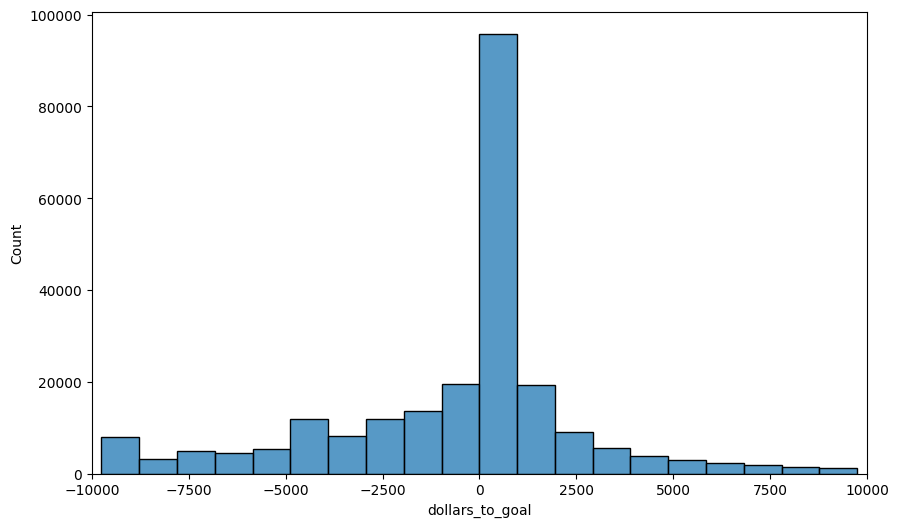

In [36]:
# Generate plotting df
plotting_df = generate_plotting_df(df)

# Add Threshold Column
plotting_df['threshold'] = plotting_df['dollars_to_goal'] >= 0

# Plot percent to goal on x axis and total number of projects on y axis
plt.figure(figsize=(10,6))
plt.xlim(-10000, 10000)
sns.histplot(data=plotting_df, x='dollars_to_goal', weights = 'n_obs', bins = 20)

Text(0.5, 0, 'Dollars to Goal')

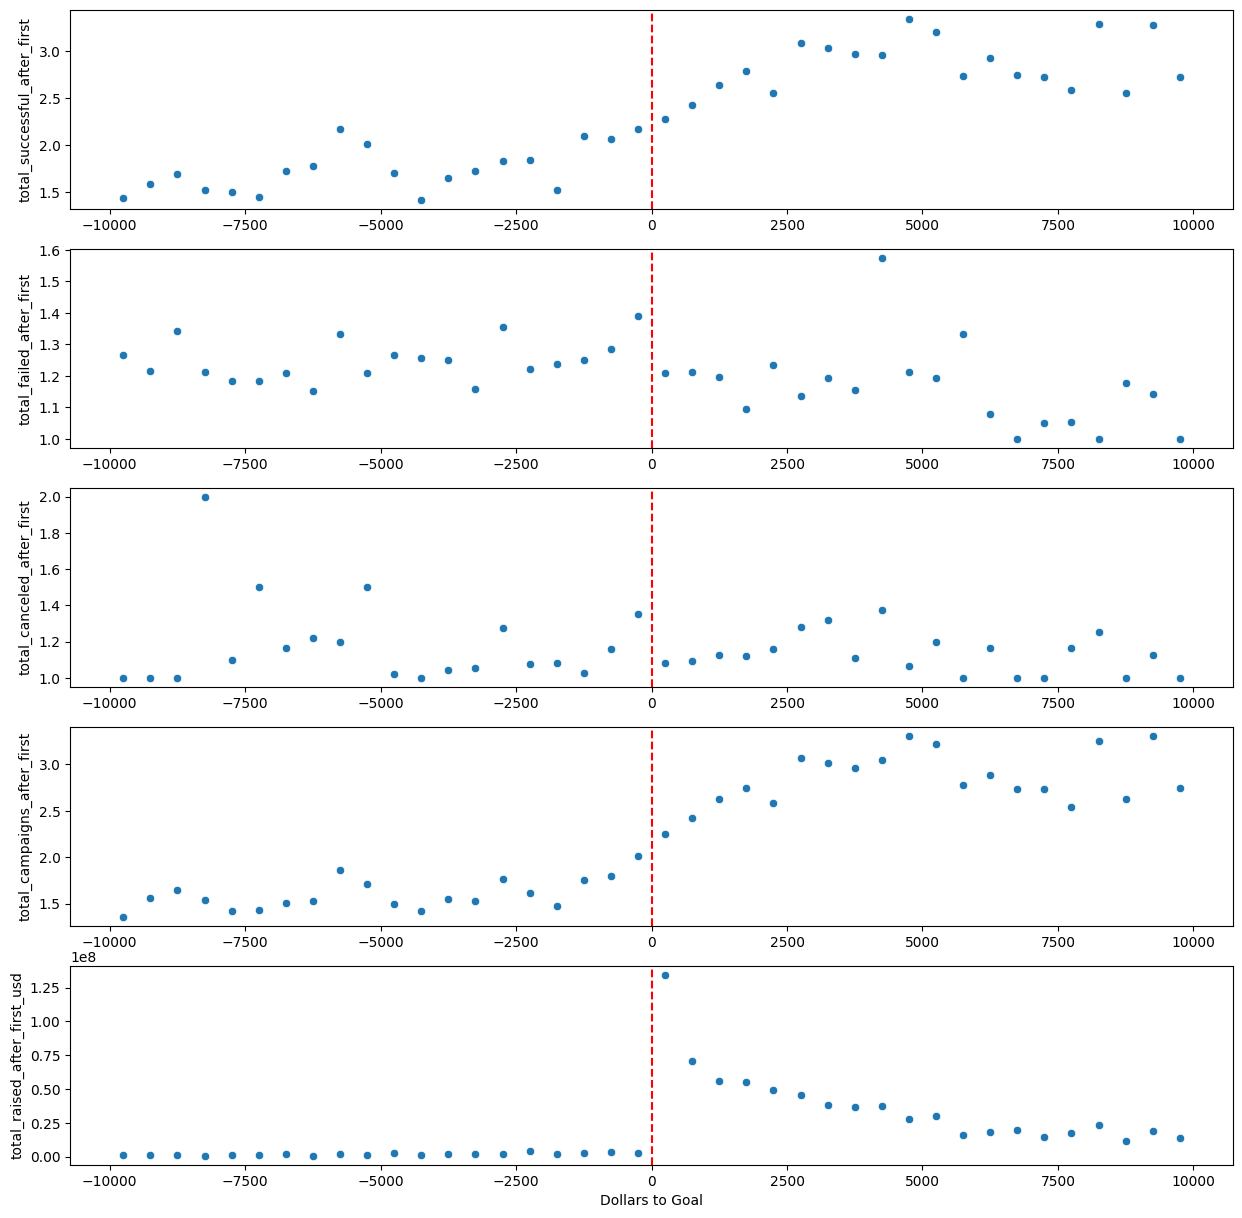

In [18]:
plt.figure(figsize=(15,15))
ax = plt.subplot(5, 1, 1)

sns.scatterplot(data=plotting_df, x = 'dollars_to_goal', y = 'total_successful_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 2)
sns.scatterplot(data = plotting_df, x = 'dollars_to_goal', y = 'total_failed_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 3)
sns.scatterplot(data = plotting_df, x = 'dollars_to_goal', y = 'total_canceled_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 4)
sns.scatterplot(data = plotting_df, x = 'dollars_to_goal', y = 'total_campaigns_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 5)
sns.scatterplot(data = plotting_df, x = 'dollars_to_goal', y = 'total_raised_after_first_usd', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('Dollars to Goal')


In [19]:
plotting_df

,dollars_to_goal_binned,total_successful_after_first,total_failed_after_first,total_canceled_after_first,total_raised_after_first_usd,total_campaigns_after_first,n_obs,dollars_to_goal,threshold
0,"(-10010.0, -9500.0]",1.430000,1.264706,1.000000,9.153303e+05,1.359408,6489,-9755.00000,False
1,"(-9500.0, -9000.001]",1.582090,1.215385,1.000000,1.009251e+06,1.556452,1543,-9250.00050,False
2,"(-9000.001, -8500.001]",1.685714,1.340909,1.000000,1.069109e+06,1.651007,1663,-8750.00100,False
3,"(-8500.001, -8000.002]",1.516667,1.213333,2.000000,7.528409e+05,1.539683,1431,-8250.00150,False
4,"(-8000.002, -7500.002]",1.500000,1.184211,1.100000,9.458010e+05,1.419355,2673,-7750.00200,False
5,"(-7500.002, -7000.003]",1.448718,1.183206,1.500000,9.447928e+05,1.428571,2350,-7250.00250,False
6,"(-7000.003, -6500.003]",1.723684,1.209302,1.166667,1.652519e+06,1.507692,2479,-6750.00300,False
7,"(-6500.003, -6000.004]",1.776316,1.152174,1.222222,7.890522e+05,1.527273,2087,-6250.00350,False
8,"(-6000.004, -5500.004]",2.175926,1.331288,1.200000,1.768216e+06,1.863454,3012,-5750.00400,False
9,"(-5500.004, -5000.005]",2.009709,1.210145,1.500000,9.557112e+05,1.709957,2398,-5250.00450,False


# Discontinuity Analysis

## Percent to Goal

In [ ]:
rdd_df = df.assign(threshold = (df['percent_to_goal'] > 1).astype(int)).sort_values('percent_to_goal').reset_index(drop=True)
rdd_df['percent_to_goal*threshold'] = rdd_df['percent_to_goal'] * rdd_df['threshold']

Naive Model

In [ ]:
model = smf.wls('total_successful_after_first ~ percent_to_goal + threshold + percent_to_goal*threshold', rdd_df).fit()

model.summary().tables[1]

In [ ]:
# Remove outliers
plotting_df = generate_plotting_df('percent_to_goal', 1, 20)


ax = plotting_df.plot.scatter(x = 'percent_to_goal', y = 'total_successful_after_first', color = "C0")

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['percent_to_goal*threshold'] = plotting_df['percent_to_goal'] * plotting_df['threshold']

exog_dict = {"percent_to_goal": plotting_df['percent_to_goal'].values, "threshold": plotting_df['threshold'].values, "percent_to_goal*threshold": plotting_df['percent_to_goal*threshold'].values}
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['percent_to_goal'] < 1]
right_plotting_df = plotting_df[plotting_df['percent_to_goal'] >= 1]
left_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
right_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.title('Regression Discontinuity')

Kernel weighted RD

In [ ]:
def kernel(R, c, h):
    indicator = (np.abs(R - c) <= h).astype(float)
    return indicator * (1 - np.abs(R - c) / h)

In [ ]:
plt.plot(sorted(rdd_df["percent_to_goal"]), kernel(rdd_df["percent_to_goal"], c=1, h=1))
plt.xlabel("Percent to Goal")
plt.ylabel("Weight")
plt.xlim(-2, 4)
plt.title("Kernel Weight by Goal Percentage");

In [ ]:
model = smf.wls("total_successful_after_first ~ percent_to_goal*threshold", data = rdd_df, weights = kernel(rdd_df['percent_to_goal'], c=1, h=1)).fit()

model.summary().tables[1]

In [ ]:
ax = plotting_df.plot.scatter(x = 'percent_to_goal', y = 'total_successful_after_first', color = "C0")

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['percent_to_goal*threshold'] = plotting_df['percent_to_goal'] * plotting_df['threshold']

exog_dict = {"percent_to_goal": plotting_df['percent_to_goal'].values, "threshold": plotting_df['threshold'].values, "percent_to_goal*threshold": plotting_df['percent_to_goal*threshold'].values}
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['percent_to_goal'] < 1]
right_plotting_df = plotting_df[plotting_df['percent_to_goal'] >= 1]
left_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
right_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
plt.title('Regression Discontinuity')

In [ ]:
plt.figure(figsize=(15,15))


exog_dict = {"percent_to_goal": plotting_df['percent_to_goal'].values, "threshold": plotting_df['threshold'].values, "percent_to_goal*threshold": plotting_df['percent_to_goal*threshold'].values}
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['percent_to_goal*threshold'] = plotting_df['percent_to_goal'] * plotting_df['threshold']

for p, cause in enumerate(["total_successful_after_first", "total_failed_after_first", "total_canceled_after_first", "total_campaigns_after_first", "total_raised_after_first"], 1):
    ax = plt.subplot(5,1,p)
    ax = plotting_df.plot.scatter(x = 'percent_to_goal', y = cause, color = "C0", ax = ax)

    m = smf.wls(f"{cause}~percent_to_goal*threshold", rdd_df, weights = kernel(rdd_df['percent_to_goal'], c=1, h=1)).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)

    plt.title(f"Impact of Kickstarter on {cause}: {np.round(ate_pct, 2)}%")
    # Convert threshold to int

    plotting_df['predictions'] = m.predict(exog_dict)
    left_plotting_df = plotting_df[plotting_df['percent_to_goal'] < 1]
    right_plotting_df = plotting_df[plotting_df['percent_to_goal'] >= 1]
    left_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
    right_plotting_df.plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
    ax.axvline(x = 1, color = 'red', linestyle = '--')
    plt.title('Regression Discontinuity')
    plt.legend()

    plt.xlim(0, 2)
    
    

plt.tight_layout()

# Dollars to Goal

In [21]:
df = df.assign(threshold = (df['dollars_to_goal'] > 1).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)
df['dollars_to_goal*threshold'] = df['dollars_to_goal'] * df['threshold']

df['dollars_to_goal_2'] = df['dollars_to_goal'] ** 2
df['dollars_to_goal_2*threshold'] = df['dollars_to_goal_2'] * df['threshold']

In [22]:
# Create df with no NAs in successful_after_first
ml_df = df.dropna(subset=['total_successful_after_first'])
print(ml_df.shape)


copy_df = df.copy()
copy_df['total_successful_after_first'] = copy_df['total_successful_after_first'].fillna(0)
filled_df = copy_df.dropna(subset=['total_successful_after_first'])
print(filled_df.shape)

(32889, 156)
(328652, 156)


## Successful after first


### Base

In [ ]:
# Fit the model
X = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = ml_df['total_successful_after_first']


model = LinearRegression(fit_intercept=True).fit(X,y)


# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_, model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

In [ ]:
table_model = smf.wls('total_successful_after_first ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                data = ml_df).fit()

table_model.summary()


In [ ]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['total_successful_after_first'], color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Total Successful (Lifetime)')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Total Successful (Lifetime)')




### Triangular Kernel

In [ ]:
weights = Kernels.triangular_kernel(ml_df['dollars_to_goal'], c = 0, h = 10000)
X, y = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']], ml_df['total_successful_after_first']

model = LinearRegression(fit_intercept=True).fit(X,y, sample_weight=weights)

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_, model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict


In [ ]:
cutoff = 0
bandwidth = 10000
weights = Kernels.triangular_kernel(ml_df['dollars_to_goal'], c = 0, h = 10000)

table_model = smf.wls('total_successful_after_first ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                data = ml_df,
                weights = weights).fit()

table_model.summary()



In [ ]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['total_successful_after_first'], color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 0, color = 'red', linestyle = '--')
plt.ylabel('Total Successful (Lifetime)')
plt.xlabel('USD to Goal')
plt.title('Completing the First Campaign on Total Successful (Lifetime) with Triangular Kernel')




### Kernel and Controls

In [ ]:
weights = Kernels.triangular_kernel(ml_df['dollars_to_goal'], c = cutoff, h = bandwidth)
weights[weights == 0] = 1e-10

all_categories = sorted(ml_df['category_name'].unique())

model = smf.wls('total_successful_after_first ~ dollars_to_goal + threshold + dollars_to_goal*threshold + goal + backers_count + staff_pick + prelaunch_activated + C(category_name, levels=all_categories)', 
                data = ml_df, 
                weights = weights).fit()

model.summary().tables[1]


### Quadratic

In [ ]:
X, y = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold', 'dollars_to_goal_2', 'dollars_to_goal_2*threshold']], ml_df['total_successful_after_first']

model = LinearRegression(fit_intercept=True).fit(X,y, sample_weight=weights)

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_, model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict


In [ ]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['total_successful_after_first'], color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']
plotting_df['dollars_to_goal_2'] = plotting_df['dollars_to_goal'] ** 2
plotting_df['dollars_to_goal_2*threshold'] = plotting_df['dollars_to_goal_2'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold', 'dollars_to_goal_2', 'dollars_to_goal_2*threshold']]
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 0, color = 'red', linestyle = '--')
plt.ylabel('Total Successful (Lifetime)')
plt.xlabel('USD to Goal')
plt.title('Completing the First Campaign on Total Successful (Lifetime) with Triangular Kernel')




## Raised after first

### Base 

In [37]:
# Create df with no NAs in successful_after_first
ml_df = df.dropna(subset=['total_raised_after_first_usd'])
print(ml_df.shape)


copy_df = df.copy()
copy_df['total_raised_after_first_usd'] = copy_df['total_raised_after_first_usd'].fillna(0)
filled_df = copy_df.dropna(subset=['total_raised_after_first_usd'])
print(filled_df.shape)

(32889, 156)
(328652, 156)


In [38]:
# Fit the model
X = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = ml_df['total_raised_after_first_usd']


model = LinearRegression(fit_intercept=True).fit(X,y)


# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_, model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '-0.0111449640',
 'threshold': '42587.5962181262',
 'dollars_to_goal*threshold': '1.9440496331'}

In [39]:
table_model = smf.wls('total_raised_after_first_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                data = ml_df).fit()

table_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                 
========================================================================================
Dep. Variable:     total_raised_after_first_usd   R-squared:                       0.167
Model:                                      WLS   Adj. R-squared:                  0.167
Method:                           Least Squares   F-statistic:                     2204.
Date:                          Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                                  12:43:11   Log-Likelihood:            -4.9126e+05
No. Observations:                         32889   AIC:                         9.825e+05
Df Residuals:                             32885   BIC:                         9.826e+05
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1.955e+04   9464.254      2.066      0.039    1003.658    3.81e+04
dollars_to_goal              -0.0111      0.029     -0.379      0.705      -0.069       0.047
threshold                  4.259e+04   1.05e+04      4.048      0.000     2.2e+04    6.32e+04
dollars_to_goal:threshold     1.9440      0.038     51.268      0.000       1.870       2.018
==============================================================================
Omnibus:                   109556.869   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      48186313994.611
Skew:                          58.495   Prob(JB):                         0.00
Kurtosis:                    5931.674   Cond. No.                     8.98e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### filed data

In [40]:
table_model = smf.wls('total_raised_after_first_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                data = filled_df).fit()

table_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                 
========================================================================================
Dep. Variable:     total_raised_after_first_usd   R-squared:                       0.063
Model:                                      WLS   Adj. R-squared:                  0.063
Method:                           Least Squares   F-statistic:                     7385.
Date:                          Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                                  12:43:14   Log-Likelihood:            -4.5523e+06
No. Observations:                        328652   AIC:                         9.105e+06
Df Residuals:                            328648   BIC:                         9.105e+06
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   717.9906    608.349      1.180      0.238    -474.356    1910.337
dollars_to_goal           -4.068e-06      0.000     -0.010      0.992      -0.001       0.001
threshold                  8238.5292    878.968      9.373      0.000    6515.778    9961.281
dollars_to_goal:threshold     0.7172      0.005    146.750      0.000       0.708       0.727
==============================================================================
Omnibus:                  1530461.243   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   32944229082906.691
Skew:                         168.318   Prob(JB):                         0.00
Kurtosis:                   49050.506   Cond. No.                     2.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Completing the First Campaign on Total Raised (Lifetime)')

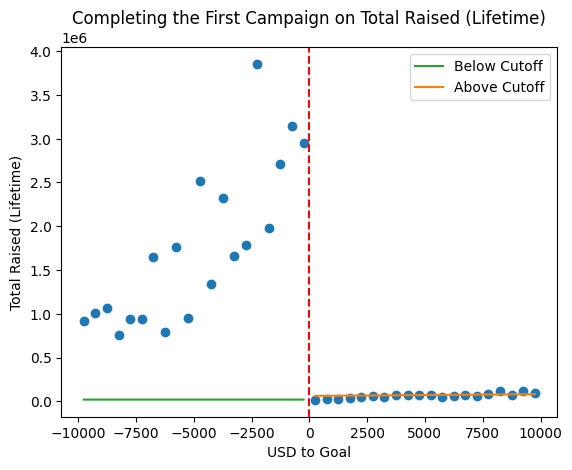

In [41]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['total_raised_after_first_usd'], color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']
plotting_df['dollars_to_goal_2'] = plotting_df['dollars_to_goal'] ** 2
plotting_df['dollars_to_goal_2*threshold'] = plotting_df['dollars_to_goal_2'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 0, color = 'red', linestyle = '--')
plt.ylabel('Total Raised (Lifetime)')
plt.xlabel('USD to Goal')
plt.title('Completing the First Campaign on Total Raised (Lifetime)')




# McCrary Test

In [ ]:
bins = np.linspace(0, 2, 20)

rdd_df['bin'] = pd.cut(rdd_df['dollars_to_goal'], bins)

# Get Bin Counts
bin_counts = rdd_df['bin'].value_counts(sort = False)

# Calculate the midpoints for each bin
midpoints = bins[:-1] + (bins[1:] - bins[:-1]) / 2

# Plot the bar plot
plt.bar(midpoints, bin_counts, width=(bins[1] - bins[0]), align='center')
plt.xlabel('Percent to Goal')
plt.ylabel('Count')
plt.title('Binned Data with Midpoints')
plt.show()


# RD Analysis with Optimal Bandwidth (IK)

Set Thresholds

In [ ]:
perc_threshold = 1
abs_threshold = 0

Identify Optimal Bandwidth

In [ ]:
bandwidth_opt_perc = rdd.optimal_bandwidth(X = rdd_df['percent_to_goal'], Y = rdd_df['total_successful_after_first'], cut=perc_threshold)
bandwidth_opt_abs = rdd.optimal_bandwidth(X = rdd_df['dollars_to_goal'], Y = rdd_df['total_successful_after_first'], cut=abs_threshold)
print("Optimal Percentage bandwidth:", bandwidth_opt_perc)
print("Optimal Absolute bandwidth:", bandwidth_opt_abs)

Restrict Data to Optimal Bandwidth

In [ ]:
perc_rdd_df = rdd.truncated_data(rdd_df, 'percent_to_goal', bandwidth_opt_perc, cut=perc_threshold)

#abs_rdd_df = rdd.truncated_data(rdd_df, 'dollars_to_goal', bandwidth_opt_abs, cut=abs_threshold)
abs_rdd_df = rdd.truncated_data(rdd_df, 'dollars_to_goal', 10000, cut=abs_threshold)

print(f"Percentage RDD Shape: {perc_rdd_df.shape}")
print(f"Absolute RDD Shape: {abs_rdd_df.shape}")



## Dollars to Goal

In [ ]:
model = smf.wls("total_successful_after_first ~ dollars_to_goal*threshold", data = abs_rdd_df, weights = kernel(abs_rdd_df['dollars_to_goal'], c=abs_threshold, h=bandwidth_opt_abs)).fit()

model.summary().tables[1]


In [ ]:
ate_pct = 100*((model.params["threshold"] + model.params["Intercept"])/model.params["Intercept"] - 1)
print(f"Impact of Winning First Kickstarter on Total Successful Projects: {np.round(ate_pct, 2)}%")

## Percent to Goal

In [ ]:
model = smf.wls("total_successful_after_first ~ percent_to_goal*threshold", data = perc_rdd_df, weights = kernel(perc_rdd_df['percent_to_goal'], c=perc_threshold, h=bandwidth_opt_perc)).fit()

model.summary().tables[1]


In [ ]:
ate_pct = 100*((model.params["threshold"] + model.params["Intercept"])/model.params["Intercept"] - 1)
print(f"Impact of Winning First Kickstarter on Total Successful Projects: {np.round(ate_pct, 2)}%")